In [5]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd

In [10]:
trans_metrics = ['OT', 'TCA', 'MMD']
score_dir = "/home/wanxinli/EHR-OT/outputs/mimic/"
group_name = 'insurance'

In [11]:

def ratios_for_metrics(eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


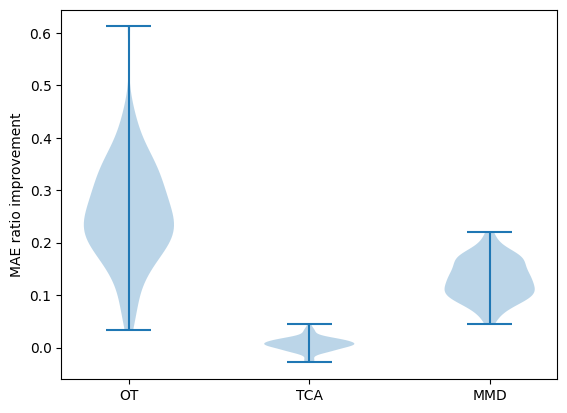

In [12]:
mae_improve_ratios = ratios_for_metrics('mae', trans_metrics)

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: mae_improve_ratios[0],
    trans_metrics[1]: mae_improve_ratios[1], 
    trans_metrics[2]: mae_improve_ratios[2]
})

# Plot the dataframe
plt.violinplot(data)
plt.xticks([1, 2, 3], labels=['OT', 'TCA', 'MMD'])
plt.ylabel("MAE ratio improvement")
plt.show()



          OT       TCA       MMD
0   0.194025  0.054396  0.152225
1  -0.011543 -0.000230  0.057700
2   0.165358  0.003401  0.071568
3   0.254200 -0.003336  0.113750
4  -0.062725 -0.014020  0.035355
..       ...       ...       ...
95 -0.035539  0.001312  0.014431
96  0.058033 -0.010829  0.114291
97  0.230139  0.007209  0.125268
98  0.181857  0.007614  0.101857
99  0.171076 -0.000064  0.082648

[100 rows x 3 columns]


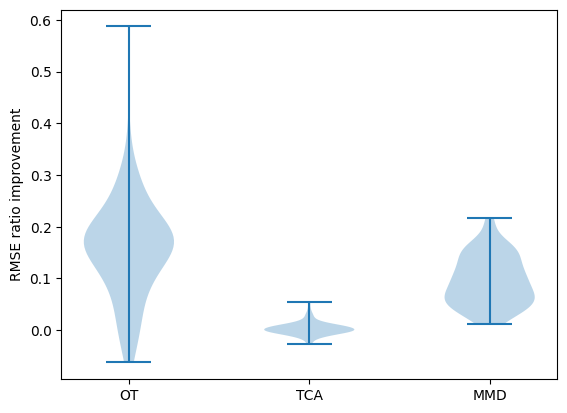

In [13]:
rmse_improve_ratios = ratios_for_metrics('rmse', trans_metrics)

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: rmse_improve_ratios[0],
    trans_metrics[1]: rmse_improve_ratios[1], 
    trans_metrics[2]: rmse_improve_ratios[2]
})
print(data)

# Plot the dataframe
plt.violinplot(data)
plt.xticks([1, 2, 3], labels=['OT', 'TCA', 'MMD'])
plt.ylabel("RMSE ratio improvement")
plt.show()

